Notebook where we perform the spatial similarity analysis between task-based patterns both at the group and subject level

In [1]:
from nilearn.image import load_img
import tqdm
from glob import glob
from os.path import join as opj

from nilearn import image

from nilearn.masking import apply_mask, unmask
from scipy.spatial.distance import squareform
import bct
from scipy.stats import norm
from statsmodels.stats.multitest import  multipletests
from scipy.stats import ttest_1samp
from scipy.spatial.distance import dice


plt.rcParams['font.family'] = ['arial']

from seaborn.algorithms import bootstrap

def _percentile_interval(data, width):
    """Return a percentile interval from data of a given width."""
    edge = (100 - width) / 2
    percentiles = edge, 100 - edge
    return np.nanpercentile(data, percentiles)

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)

# Similarities at group-level

In [3]:
experiment_dir = Path(glob("../results/experiments/*/shen/pipeline_main.yaml")[0]).parent.as_posix()

pattern = opj(experiment_dir, "task-stroop/node/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = opj(experiment_dir, "task-msit/node/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = opj(experiment_dir, "task-stroop/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
stroop_edge_ef = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef.append(stroop_edge_data)
stroop_edge_ef = np.array(stroop_edge_ef)

pattern = opj(experiment_dir, "task-msit/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
msit_edge_ef = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef.append(msit_edge_data)
    
msit_edge_ef = np.array(msit_edge_ef)

In [4]:
print(stroop_node_ef.shape, "", msit_node_ef.shape)
print(stroop_edge_ef.shape, "", msit_edge_ef.shape)

(242, 268)  (242, 268)
(242, 35778)  (242, 35778)


In [5]:
t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_node_ef, popmean=0)
t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_node_ef, popmean=0)

t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_edge_ef, popmean=0)
t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_edge_ef, popmean=0)

In [6]:
rho, _ = stats.spearmanr(t_node_stroop, t_node_msit)
dsc = 1-dice(multipletests(p_node_stroop, method="bonferroni")[0],
             multipletests(p_node_msit, method="bonferroni")[0])
print("NODE T-similarity: ", rho, "DSC: ", dsc)

rho, _ = stats.spearmanr(t_edge_stroop, t_edge_msit)
dsc = 1-dice(multipletests(p_edge_stroop, method="bonferroni")[0],
             multipletests(p_edge_msit, method="bonferroni")[0])
print("EDGE T-similarity: ", rho, "DSC: ", dsc)

# Now matching thresholds on both cases
n_rois = len(p_node_stroop)
thr = 0.05/n_rois

print("Node-based threshold")
print(1-dice(p_node_stroop<thr, p_node_msit<thr))
print(1-dice(p_edge_stroop<thr, p_edge_msit<thr))

print("Edge-based threshold")
n_links = len(p_edge_stroop)
thr = 0.05/n_links

print(1-dice(p_node_stroop<thr, p_node_msit<thr))
print(1-dice(p_edge_stroop<thr, p_edge_msit<thr))

NODE T-similarity:  0.8720679630958443 DSC:  0.8523676880222841
EDGE T-similarity:  0.6521628935220959 DSC:  0.42304385210662077
Node-based threshold
0.8523676880222841
0.4345843563661873
Edge-based threshold
0.8092105263157895
0.42304385210662077


Check that same similarity rates are obtained when sub-sampling the number of links to the same number of regions (268)

In [7]:
rng = np.random.RandomState(0)
n_boots = 10000
n_links = len(p_edge_stroop)
n_rois = len(p_node_stroop) 
sampled_link_corrs = np.zeros(n_boots)
for ii in tqdm.tqdm_notebook(range(n_boots)):
    idxs_boot = rng.choice(np.arange(n_links), size=n_rois, replace=False)
    sampled_link_corrs[ii] = stats.spearmanr(t_edge_stroop[idxs_boot],
                                             t_edge_msit[idxs_boot])[0]

/tmp/ipykernel_307873/3821019135.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm.tqdm_notebook(range(n_boots)):


  0%|          | 0/10000 [00:00<?, ?it/s]

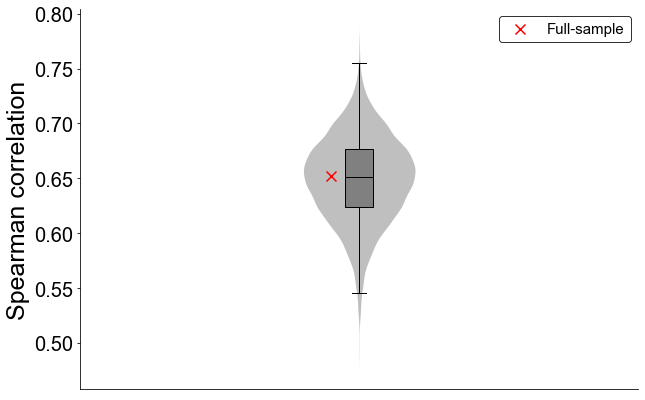

In [8]:
plot_df = pd.DataFrame({"y":sampled_link_corrs})
plot_df["hue"] = "Sub-samples"
fig, ax = plt.subplots(figsize=(10,7))
#sns.stripplot(y=sampled_link_corrs,label="Sub-samples", orient="v", alpha=0.2, jitter=0.03)
sns.violinplot(y="y", hue="hue", data=plot_df, width=0.2, linewidth=0, inner=None, color="grey")
plt.setp(ax.collections[0], alpha=0.5)
sns.boxplot(y="y", hue="hue", data=plot_df, width=0.05, color="grey", 
            boxprops={'zorder': 2, 'edgecolor': 'k'}, 
            medianprops={'color': 'k'}, capprops={'color': 'k'}, whiskerprops={'color': 'k'},
            linewidth=1., fliersize=0)
ax.scatter(x = -0.05, y= stats.spearmanr(t_edge_stroop,t_edge_msit)[0], c="red", s=100,
           marker="x", label='Full-sample')
ax.set_xlim([-0.5, 0.5])
plt.legend(fontsize=15, edgecolor='k')
#ax.set_title("Similarity of task-based connectivity \n maps between Stroop and MSIT", 
 #            size=35)
ax.set_ylabel("Spearman correlation", size=25)
ax.tick_params(labelsize=20)
ax.set_xticks([])
ax.set_xticklabels("", size=0)
sns.despine()
plt.savefig("../plots/sim_edge_subsampling_2.svg")

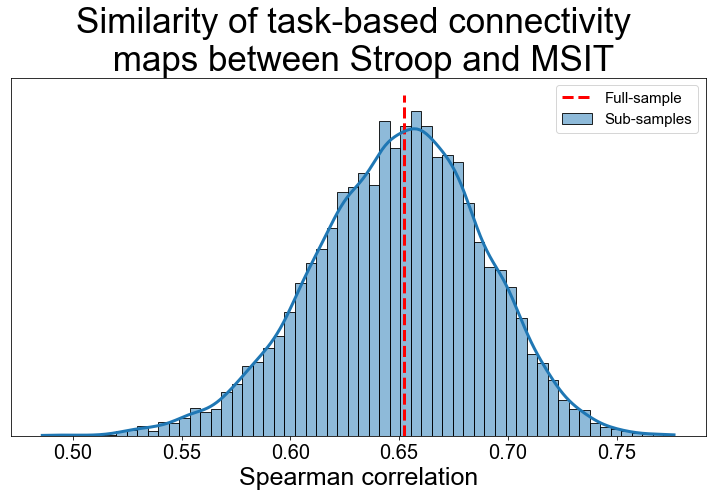

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(sampled_link_corrs, kde=True, ax=ax, alpha=0.5, line_kws={'linewidth':3}, 
             label="Sub-samples")
ax.vlines(x = stats.spearmanr(t_edge_stroop,t_edge_msit)[0], 
           ymin=0, ymax=ax.get_ylim()[1], color='red', linestyle='dashed', label='Full-sample', linewidth=3)
ax.tick_params(labelsize=20)
ax.set_yticks([])
ax.set_yticklabels("", size=0)
ax.set_ylabel("")
ax.set_xlabel("Spearman correlation", size=25)
ax.set_title("Similarity of task-based connectivity \n maps between Stroop and MSIT", 
             size=35)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.png")
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.svg")
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.pdf")

In [8]:
print(stats.spearmanr(t_edge_stroop,t_edge_msit)[0])
print(np.round(np.mean(sampled_link_corrs), 2))
print(np.round(np.std(sampled_link_corrs), 2))

0.6521628935220959
0.65
0.04


## GROUP-LEVEL

In [20]:
# Spearman similarity between tasks varying the number of subjects
from scipy.stats import spearmanr

rng = np.random.RandomState(0)
n_shuffles = 10
n_points = 10
thresholds = [1e-6, 1e-4, 1e-2]
n_thr = len(thresholds)

or_node, or_edge = np.zeros(shape=(n_thr, n_points, n_shuffles)), np.zeros(shape=(n_thr, n_points, n_shuffles))
cors_node, cors_edge = np.zeros(shape=(n_points, n_shuffles)), np.zeros(shape=(n_points, n_shuffles))

for ii, prop in tqdm.tqdm(enumerate(np.linspace(0.1, 1, 10))):
    for jj, shuffle in enumerate(range(n_shuffles)):
        idxs_shuffle = rng.choice(np.arange(n_subjects), size=n_subjects, replace=False)
        idxs_sub = idxs_shuffle[:int(prop*n_subjects)]

        t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_node_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp,
                                                       axis=0, 
                                                       arr=msit_node_ef[idxs_sub,:], 
                                                       popmean=0)

        t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_edge_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=msit_edge_ef[idxs_sub,:], 
                                                       popmean=0)

        # Correlations
        cors_node[ii,jj] = spearmanr(t_node_stroop, t_node_msit)[0]
        cors_edge[ii,jj] = spearmanr(t_edge_stroop, t_edge_msit)[0]
        
        for kk, alpha in enumerate(thresholds):
            or_node[kk,ii,jj] = 1-dice(p_node_stroop<alpha, p_node_msit<alpha)
            or_edge[kk,ii,jj] = 1-dice(p_edge_stroop<alpha, p_edge_msit<alpha)

0it [00:00, ?it/s]/home/javi/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:1420: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
10it [15:01, 90.18s/it]


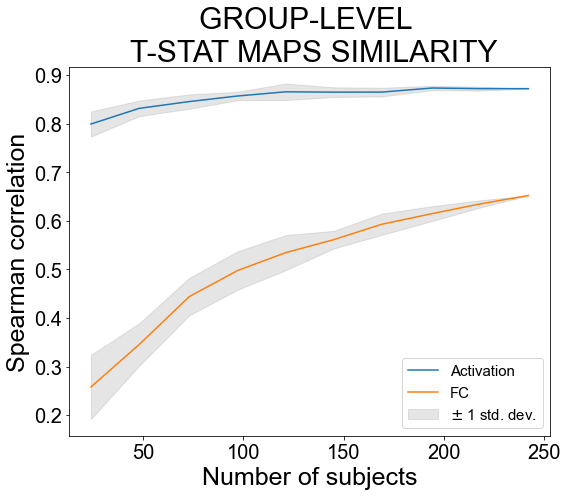

In [21]:
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8,7))

mean_ = np.mean(cors_node, axis=1)
std_ = np.std(cors_node, axis=1)

ax.plot(xticks, mean_, label = "Activation")

ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

mean_ = np.mean(cors_edge, axis=1)
std_ = np.std(cors_edge, axis=1)

ax.plot(xticks, mean_, label = "FC")
ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2)
ax.legend()
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n T-STAT MAPS SIMILARITY", size=30)
ax.legend(fontsize=15)
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/similarity_analysis_roi.png", dpi=300)
plt.savefig("../plots/similarity_analysis_roi.svg", dpi=300)
plt.savefig("../plots/similarity_analysis_roi.pdf", dpi=300)

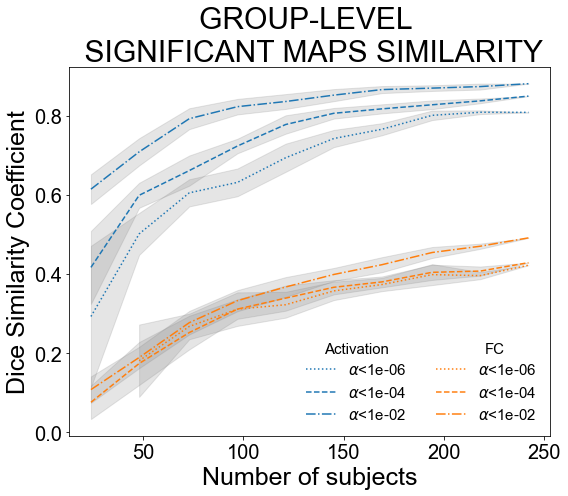

In [22]:
# Overlapping analysis between tasks using the DICE coefficient, varying the number of subjects and thresholds
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8, 7))

mean_ = np.mean(or_node, axis=2)
std_ = np.std(or_node, axis=2)

for (kk, alpha), lstyle  in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha, 
                c="C0", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

mean_ = np.mean(or_edge, axis=2)
std_ = np.std(or_edge, axis=2)

for (kk, alpha), lstyle in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha,
                c="C1", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

ax.legend(fontsize=15, ncol=2, frameon=False)
ax.set_ylabel("Dice Similarity Coefficient", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n SIGNIFICANT MAPS SIMILARITY", size=30)

ax.text(x=140, y=0.2, s="Activation", size=15)
ax.text(x=220, y=0.2, s="FC", size=15)

ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/overlapping_analysis_roi.png", dpi=300)
plt.savefig("../plots/overlapping_analysis_roi.svg", dpi=300)
plt.savefig("../plots/overlapping_analysis_roi.pdf", dpi=300)

## SUBJECT LEVEL

In [9]:
from scipy.stats import spearmanr
sims_node = [spearmanr(a,b)[0] for a, b in zip(stroop_node_ef, msit_node_ef)]
sims_edge = [spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef, msit_edge_ef)]

In [11]:
print(np.round(np.mean(sims_node), 3), np.round(np.std(sims_node), 3))
print(np.round(np.mean(sims_edge), 3), np.round(np.std(sims_edge), 3))


0.314 0.17
0.038 0.059


In [26]:
from scipy.stats import ttest_rel
print(ttest_rel(sims_node, sims_edge))

print(np.round(ttest_rel(sims_node, sims_edge).statistic/np.sqrt(len(sims_node)-1),3))

Ttest_relResult(statistic=24.58528676675227, pvalue=1.2660217756538414e-67)
1.584


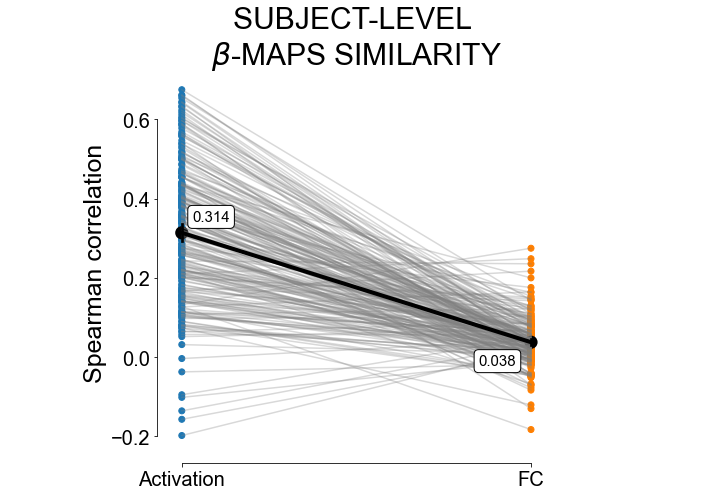

In [29]:
fig, ax= plt.subplots(figsize=(10,7))

for x,y in zip(sims_node, sims_edge):
    ax.scatter([0,1], [x, y], c=[sns.color_palette("Paired")[1], 
                                  sns.color_palette("Paired")[7]])
    if x>y:
        c="grey"   
    else:
        c="grey"
        
    ax.plot([0,1], [x, y], color=c, alpha=0.3)
    
sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(pd.DataFrame({'node':sims_node, 'edge':sims_edge})), color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xticklabels(["Activation", "FC"], size=20)
ax.set_xlabel("")
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-MAPS SIMILARITY", size=30)
sns.despine(offset={'bottom':10, 'left':-150}, trim=True)

ax.annotate(np.round(np.mean(sims_node), 3), 
                xy=[0+ 0.03, np.mean(sims_node) + 0.03], 
                size=15, bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_edge), 3), 
            xy=[0.85, -0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))
plt.tight_layout()
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.png", dpi=300)
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.svg", dpi=300)
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.pdf", dpi=300)

In [116]:
# Mean and confidence intervals
print("activation")
print(np.round(np.mean(sims_node),3))
print(np.round(_percentile_interval(bootstrap(sims_node, n_boot=1000, func=np.mean, seed=1234), width=95), 3))


# Mean and confidence intervals
print("connectivity")
print(np.round(np.mean(sims_edge),3))
print(np.round(_percentile_interval(bootstrap(sims_edge, n_boot=1000, func=np.mean, seed=1234), width=95), 3))

activation
0.314
[0.292 0.335]
connectivity
0.038
[0.031 0.045]


In [30]:
import dabest
dabest.load(pd.DataFrame({'activation': sims_node, 'FC': sims_edge, 'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "FC"), id_col='id', paired=True).cohens_d.statistical_tests

/home/javi/anaconda3/lib/python3.8/site-packages/dabest/_classes.py:163: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_data.loc[:, self.__xvar] = pd.Categorical(plot_data[self.__xvar],


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,activation,FC,242,242,Cohen's d,True,-2.167186,95,-2.40447,-1.896176,0.0,3.676574e-39,430.0,1.266022e-67,24.585287


In [31]:
dabest.effsize.cohens_d(control=sims_edge, test=sims_node, is_paired=True)

2.1671857824312206

In [32]:
res = dabest.load(pd.DataFrame({'activation': sims_node, 'FC': sims_edge, 'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "FC"), id_col='id', paired=True)

/home/javi/anaconda3/lib/python3.8/site-packages/dabest/_classes.py:163: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_data.loc[:, self.__xvar] = pd.Categorical(plot_data[self.__xvar],


In [33]:
res.cohens_d

DABEST v0.3.1
             
Good evening!
The current time is Wed Aug  2 12:17:15 2023.

The paired Cohen's d between activation and FC is -2.17 [95%CI -2.4, -1.9].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

# ADDITIONAL QUESTIONS

## Question 1: 

### "What's the similarity between networks if we only concentrate on the subnetwork that higher respond to the task?"

To do this, we concentrate on a subset of regions that are most evoked in both tasks (absolute d's Cohen > 0.8) and compute similarities using just the sub-network from these regions.

In [27]:
# Cohen's d at group level.
abs_d_node_stroop = abs(t_node_stroop)/np.sqrt(242-1)
abs_d_node_msit = abs(t_node_msit)/np.sqrt(242-1)

mask_roi = (abs_d_node_stroop>0.8) & (abs_d_node_msit>0.8)

print(f"# of most evoked regions: {sum(mask_roi)}")

mask_edge = squareform(np.outer(mask_roi, mask_roi), checks=False)

print("NODE similarity (group-level): ", 
      stats.spearmanr(t_node_stroop[mask_roi], t_node_msit[mask_roi])[0])
print("EDGE similarity (group-level): ", 
      stats.spearmanr(t_edge_stroop[mask_edge], t_edge_msit[mask_edge])[0])

sims_node_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_node_ef[:,mask_roi], msit_node_ef[:,mask_roi])]
sims_edge_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef[:, mask_edge], msit_edge_ef[:,mask_edge])]

print("NODE similarity (subject-level): ", "mean:", np.mean(sims_node_masked), 
      "sd:", np.std(sims_node_masked))
print("EDGE similarity (subject-level): ",
      "mean:", np.mean(sims_edge_masked), "sd:", np.std(sims_edge_masked))

# of most evoked regions: 21
NODE similarity (group-level):  0.8896103896103895
EDGE similarity (group-level):  0.7381242852931553
NODE similarity (subject-level):  mean: 0.6451379199313083 sd: 0.21700732487133442
EDGE similarity (subject-level):  mean: 0.04052806697434797 sd: 0.1332266671559394


<AxesSubplot:xlabel='variable', ylabel='value'>

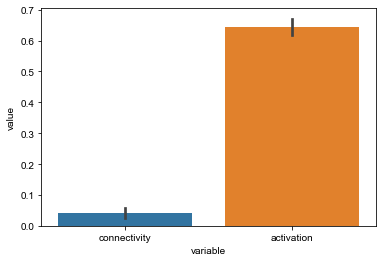

In [28]:
sns.barplot(x='variable', y='value', 
            data=pd.melt(pd.DataFrame({'connectivity':sims_edge_masked, 'activation':sims_node_masked})))

## Question 2: 

### How is between task similarity looking just at the whole-brain connecitivy pattern of each region? I.e. which regions exhibit a similarity rate more comparable to that from node activations?

We will explore the relation between task average node activation and similarity between nodes’ connectivity profiles

In [37]:
n_rois = 268
roiwise_edge_sims  = [stats.spearmanr(squareform(t_edge_stroop)[ii,:][np.arange(n_rois)!=ii],
                                      squareform(t_edge_msit)[ii,:][np.arange(n_rois)!=ii])[0] for ii in range(n_rois)
                     ]
roiwise_edge_sims = np.array(roiwise_edge_sims)

In [38]:
def map_array_atlas(labels_img, data, background_label=0):
    
    from nilearn.image import load_img, new_img_like
    
    labels_image_data = load_img(labels_img).get_fdata()
    # Number of regions excluding the background
    
    labels = np.unique(labels_image_data)
    labels = labels[labels != background_label]
    
    number_of_regions = np.sum(labels != background_label)
    
    new_data = np.zeros_like(labels_image_data)
    
    for label, new_val in zip(labels, data):
        new_data[labels_image_data==label] = new_val
        
    return new_img_like(labels_img, new_data)

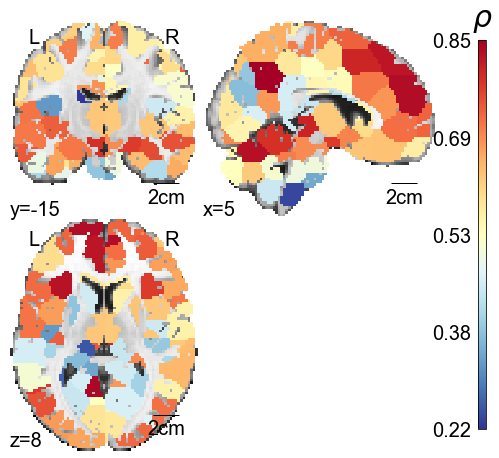

In [54]:
from nilearn.datasets import load_mni152_template
from nilearn.plotting import find_parcellation_cut_coords, plot_img

atlas_img = "../data/atlases/shen_2mm_268_parcellation.nii.gz"

display = plot_img(map_array_atlas(atlas_img, roiwise_edge_sims), 
                   cmap=plt.cm.RdYlBu_r, 
                   display_mode='tiled', 
                   cut_coords = (5,-15,8),
                   bg_img = load_mni152_template(), 
                   draw_cross=False, black_bg=False,
                   threshold=1e-6, colorbar=True)
display.annotate(size=20, scalebar=True, scale_size=2)
display._colorbar_ax.yaxis.set_tick_params(width=0, labelsize=20)
display._colorbar_ax.set_title(r'$\rho$', {'color':'k', 'fontsize':30}, loc="center", y=1.02)
display.savefig("../plots/supplementary/regionwise_sims_map.svg", dpi=300)
display.savefig("../plots/supplementary/regionwise_sims_map.png", dpi=300)
display.savefig("../plots/supplementary/regionwise_sims_map.pdf", dpi=300)

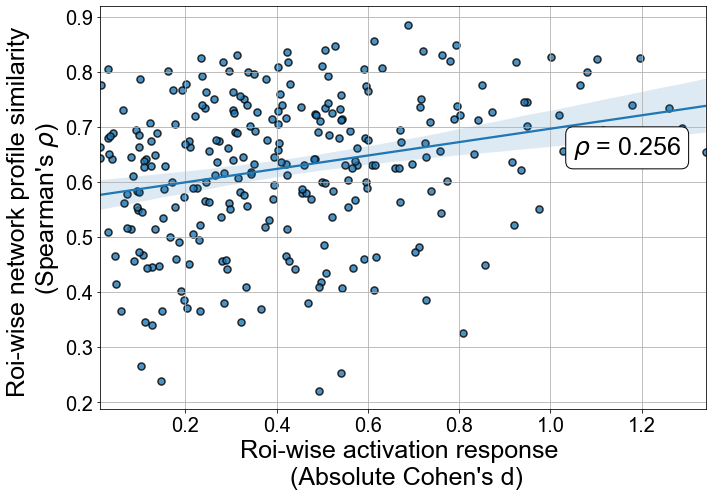

In [82]:
fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x='activation', y='rois_edge_sim', 
            data=pd.DataFrame({'rois_edge_sim':roiwise_edge_sims, 
                               'activation':np.mean([abs_d_node_stroop, abs_d_node_msit], axis=0)}),
            scatter_kws = {'edgecolors': 'black', 'linewidths':1.5, 's': 50},
            ax=ax)
ax.tick_params(labelsize=20)
ax.set_xlabel("Roi-wise activation response \n (Absolute Cohen's d)", size=25)
ax.set_ylabel("Roi-wise network profile similarity \n" + r"(Spearman's $\rho$)", size=25)
rho = stats.spearmanr(roiwise_edge_sims, np.mean([abs_d_node_stroop, abs_d_node_msit], axis=0))[0]
ax.annotate(r"$\rho$ = "f"{np.round(rho,3)}", 
            xy=[1.05, 0.65], 
            size=25, bbox = dict(boxstyle="round", fc="1.0", ec="0.0", alpha=1) )
ax.grid()
plt.tight_layout()
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.svg", dpi=300)
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.png", dpi=300)
plt.savefig("../plots/supplementary/regionwise_sims_vs_activations_scatter.pdf", dpi=300)

## QUESTION 3:  

### Comparison of similarity rates with task conditions included. Our conclusions regarding connectivity are just because we removed task events?

In [35]:
experiment_2_dir = Path(glob("../results/experiments/*/shen/pipeline_edge_w_tasks.yaml")[0]).parent.as_posix()

pattern = opj(experiment_2_dir, "task-stroop/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
stroop_edge_ef_wtasks = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef_wtasks.append(stroop_edge_data)
stroop_edge_ef_wtasks = np.array(stroop_edge_ef_wtasks)

pattern = opj(experiment_2_dir, "task-msit/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
msit_edge_ef_wtasks = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef_wtasks.append(msit_edge_data)
    
msit_edge_ef_wtasks = np.array(msit_edge_ef_wtasks)

sims_edge_wtasks = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_wtasks, msit_edge_ef_wtasks)]

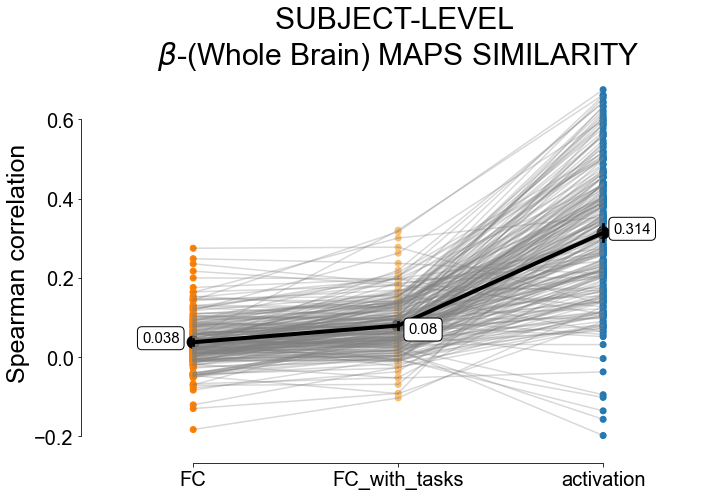

In [86]:
fig, ax= plt.subplots(figsize=(10,7))

for x,y, z in zip(sims_edge, sims_edge_wtasks, sims_node):
    ax.scatter([0,1, 2], [x, y, z], c=[sns.color_palette("Paired")[7], 
                                  sns.color_palette("Paired")[6], sns.color_palette("Paired")[1]])
    
    ax.plot([0,1], [x, y], color="grey", alpha=0.3)
    ax.plot([1,2], [y, z], color="grey", alpha=0.3)

sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(pd.DataFrame({'FC':sims_edge, 
                                         'FC_with_tasks':sims_edge_wtasks, 
                                         'activation': sims_node})), 
              color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xlabel("")
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-(Whole Brain) MAPS SIMILARITY", size=30)
ax.annotate(np.round(np.mean(sims_edge), 3), xy=[-0.25, np.mean(sims_edge)], size=15, 
            bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_edge_wtasks), 3), xy=[1.05, np.mean(sims_edge_wtasks)-0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_node), 3), xy=[2.05, np.mean(sims_node)], size=15, 
           bbox = dict(boxstyle="round", fc="1.0"))

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_w_tasks.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks.pdf", dpi=300)

In [36]:
# Mean and confidence intervals
print(np.round(np.mean(sims_edge_wtasks),3))
print(np.round(_percentile_interval(bootstrap(sims_edge_wtasks, n_boot=1000, func=np.mean, seed=1234), width=95), 3))

0.08
[0.071 0.088]


In [37]:
print(ttest_rel(sims_node, sims_edge_wtasks))
print(np.round(ttest_rel(sims_node, sims_edge_wtasks).statistic/np.sqrt(len(sims_node)-1), 3))

Ttest_relResult(statistic=23.835497706757337, pvalue=2.5310332449584028e-65)
1.535


In [40]:
import dabest
dabest.load(pd.DataFrame({'activation': sims_node, 'FC': sims_edge_wtasks, 
                          'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "FC"), id_col='id', paired='baseline').cohens_d.statistical_tests

/home/javi/anaconda3/lib/python3.8/site-packages/dabest/_classes.py:295: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_data.loc[:, self.__xvar] = pd.Categorical(plot_data[self.__xvar],


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,activation,FC,242,242,Cohen's d,baseline,-1.807069,95,-2.012448,-1.575788,0.0,1.633469e-38,554.0,2.531033e-65,23.835498


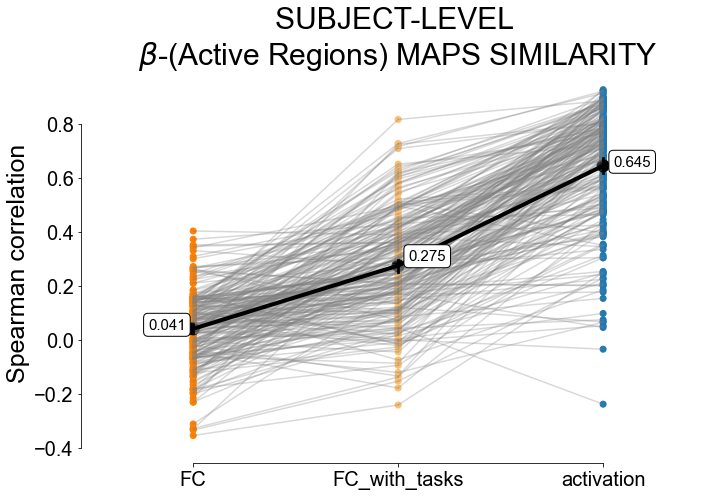

In [87]:
fig, ax= plt.subplots(figsize=(10,7))

sims_edge_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef[:,mask_edge], 
                                                            msit_edge_ef[:,mask_edge])]
sims_edge_wtasks_masked = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_wtasks[:,mask_edge], 
                                                                   msit_edge_ef_wtasks[:,mask_edge])]

for x,y,z in zip(sims_edge_masked, sims_edge_wtasks_masked, sims_node_masked):
    ax.scatter([0,1,2], [x, y, z], c=[sns.color_palette("Paired")[7], 
                                      sns.color_palette("Paired")[6], 
                                      sns.color_palette("Paired")[1]])
    
    ax.plot([0,1], [x, y], color="grey", alpha=0.3)
    ax.plot([1,2], [y, z], color="grey", alpha=0.3)

sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(
                  pd.DataFrame(
                  {'FC':sims_edge_masked,
                   'FC_with_tasks':sims_edge_wtasks_masked,
                  'activation': sims_node_masked})), 
              color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
#ax.set_xticklabels(["Activation", "Connectivity"], size=20)
ax.set_xlabel("")
ax.annotate(np.round(np.mean(sims_edge_masked), 3), xy=[-0.22, np.mean(sims_edge_masked)], size=15, 
           bbox = dict(boxstyle="round", fc="1.0"))
ax.annotate(np.round(np.mean(sims_edge_wtasks_masked), 3), 
            xy=[1.05, np.mean(sims_edge_wtasks_masked)+0.02], 
            bbox = dict(boxstyle="round", fc="1.0"),
            size=15)
ax.annotate(np.round(np.mean(sims_node_masked), 3), xy=[2.05, np.mean(sims_node_masked)], size=15,
           bbox = dict(boxstyle="round", fc="1.0"))
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-(Active Regions) MAPS SIMILARITY", size=30)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_w_tasks_actregs.pdf", dpi=300)

## QUESTION 4:  

### Would we observe same findings had we used a parcellation?

In [97]:
stroop_node_ef_dict = dict()
msit_node_ef_dict = dict()
stroop_edge_ef_dict = dict()
msit_edge_ef_dict = dict()

experiment_dir = Path(glob("../results/experiments/*/*/pipeline_main.yaml")[0]).parent.parent.as_posix()
print(experiment_dir)

for atlas_name in ["shen", "craddock", "schaefer"]:
    pattern = opj(experiment_dir, atlas_name, 
                  "task-stroop/node/sub-%d/Incongruent-Congruent/effect_size.nii.gz")

    stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                               for subj in final_subjects])
    stroop_node_ef_dict[atlas_name] = stroop_node_ef

    pattern = opj(experiment_dir, atlas_name, 
                  "task-msit/node/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
    msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                               for subj in final_subjects])
    msit_node_ef_dict[atlas_name] = msit_node_ef
    
    pattern = opj(experiment_dir, atlas_name, 
                  "task-stroop/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
    stroop_edge_ef = []
    for subj in final_subjects:
        stroop_edge_data = image.load_img(pattern % subj).get_fdata()
        stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
        stroop_edge_ef.append(stroop_edge_data)
    stroop_edge_ef_dict[atlas_name] = np.array(stroop_edge_ef)
    
    pattern = opj(experiment_dir, atlas_name, 
                  "task-msit/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
    msit_edge_ef = []
    for subj in final_subjects:
        msit_edge_data = image.load_img(pattern % subj).get_fdata()
        msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
        msit_edge_ef.append(msit_edge_data)

    msit_edge_ef_dict[atlas_name] = np.array(msit_edge_ef)

../results/experiments/pipeline_events-1_denoise-fir_whiten-ar1_hrf-1_zscore-0_gsr-1


In [98]:
# atlas-wise subject level sims
sims_node_dict = dict()
sims_edge_dict = dict()

for atlas_name in ["shen", "craddock", "schaefer"]:
 
    sims_node_dict[atlas_name] = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_node_ef_dict[atlas_name], 
                                                                          msit_node_ef_dict[atlas_name])]
    sims_edge_dict[atlas_name] = [stats.spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef_dict[atlas_name], 
                                                                          msit_edge_ef_dict[atlas_name])]

In [99]:
for atlas_name in ["shen", "craddock", "schaefer"]:
    print(atlas_name, "NODE", np.mean(sims_node_dict[atlas_name]))
    print(atlas_name, "EDGE", np.mean(sims_edge_dict[atlas_name]), np.std(sims_edge_dict[atlas_name]))

shen NODE 0.3139534559608002
shen EDGE 0.03788633772213205 0.05933855568537778
craddock NODE 0.3644661881009836
craddock EDGE 0.05110659549501477 0.07580400266542082
schaefer NODE 0.34809882643760315
schaefer EDGE 0.05582838145014686 0.07603876567562234


In [100]:
thr1 = 0.05
thr2 = 0.0005
thr3 = 0.000005
for atlas_name in ["shen", "craddock", "schaefer"]:
    
    
    t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=stroop_node_ef_dict[atlas_name], 
                                                       popmean=0)
    t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp, 
                                                   axis=0, 
                                                   arr=msit_node_ef_dict[atlas_name], 
                                                   popmean=0)

    t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=stroop_edge_ef_dict[atlas_name], 
                                                       popmean=0)
    t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, 
                                                   axis=0, 
                                                   arr=msit_edge_ef_dict[atlas_name], 
                                                   popmean=0)
    print(f"GROUP-LEVEL ATLAS:{atlas_name}")
    r, _ = stats.spearmanr(t_node_stroop, t_node_msit)
    
    dsc1 = 1-dice(p_node_stroop<thr1, p_node_msit<thr1)
    dsc2 = 1-dice(p_node_stroop<thr2, p_node_msit<thr2)
    dsc3 = 1-dice(p_node_stroop<thr3, p_node_msit<thr3)
    
    print("NODE T-similarity: ", r, "DSC:", [dsc1, dsc2, dsc3])
    
    r, _ = stats.spearmanr(t_edge_stroop, t_edge_msit)
    dsc1 = 1-dice(p_edge_stroop<thr1, p_edge_msit<thr1)
    dsc2 = 1-dice(p_edge_stroop<thr2, p_edge_msit<thr2)
    dsc3 = 1-dice(p_edge_stroop<thr3, p_edge_msit<thr3)
    
    print("EDGE T-similarity: r", r, "DSC:", "DSC:", [dsc1, dsc2, dsc3])
    print("")

GROUP-LEVEL ATLAS:shen
NODE T-similarity:  0.8720679630958443 DSC: [0.8957871396895787, 0.8509485094850948, 0.8113207547169812]
EDGE T-similarity: r 0.6521628935220959 DSC: DSC: [0.5435080507022954, 0.44306125335973967, 0.4164102564102564]

GROUP-LEVEL ATLAS:craddock
NODE T-similarity:  0.8846291157278934 DSC: [0.8902077151335311, 0.8310810810810811, 0.8208955223880597]
EDGE T-similarity: r 0.7210848567904024 DSC: DSC: [0.616764652403176, 0.5015045135406219, 0.46755162241887904]

GROUP-LEVEL ATLAS:schaefer
NODE T-similarity:  0.8279081977049428 DSC: [0.8621700879765396, 0.8163265306122449, 0.7744360902255639]
EDGE T-similarity: r 0.7117650718941699 DSC: DSC: [0.6099952741020793, 0.5423825074542099, 0.5111607142857143]



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


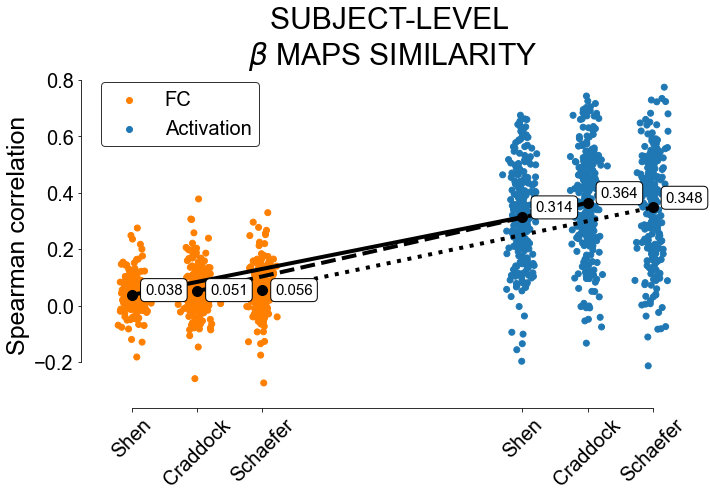

In [103]:
sims_node_df = pd.DataFrame(sims_node_dict)
sims_node_df['measure'] = "activation"

sims_edge_df = pd.DataFrame(sims_edge_dict)
sims_edge_df['measure'] = "FC"

sims_both_df = pd.concat([sims_node_df, sims_edge_df], axis=0)

ig, ax= plt.subplots(figsize=(10,7))

for tick, lt, atlas_name in zip([-0.05,0,0.05],
                                ['-', "--", ":"],
                            ["shen", "craddock", "schaefer"]):
    for x,y in zip(sims_edge_dict[atlas_name], sims_node_dict[atlas_name]):
        ax.scatter([0+tick + np.random.normal(loc=0, scale=0.005), 
                    0.3+tick + np.random.normal(loc=0, scale=0.005)], 
                   [x, y], c=[sns.color_palette("Paired")[7], 
                              sns.color_palette("Paired")[1]])
        
        #ax.plot([0+tick, 0.3+tick], [x, y], color="grey", alpha=0.1)
    
    mu_edge = np.mean(sims_edge_dict[atlas_name])
    cis_edge = _percentile_interval(bootstrap(sims_edge_dict[atlas_name], n_boot=1000, func=np.mean), 
                               width=95)
    
    mu_node = np.mean(sims_node_dict[atlas_name])
    cis_node = _percentile_interval(bootstrap(sims_node_dict[atlas_name], n_boot=1000, func=np.mean), 
                               width=95)
    
    ax.scatter([0+tick, 0.3+tick], [mu_edge, mu_node], 
               c='black', s=100)
    ax.plot([0+tick, 0.3+tick], [mu_edge, mu_node], color="black", linestyle=lt, linewidth=4)
    
    errbar = np.row_stack((abs(cis_edge-mu_edge), abs(cis_node-mu_node)))
    
    , 
    ax.annotate(np.round(np.mean(sims_edge_dict[atlas_name]), 3), 
                xy=[0+tick + 0.01, np.mean(sims_edge_masked)], 
                size=15, bbox = dict(boxstyle="round", fc="1.0"))
    ax.annotate(np.round(np.mean(sims_node_dict[atlas_name]), 3), 
                xy=[0.3+tick+ 0.01, np.mean(sims_node_dict[atlas_name])+0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))

    
ax.set_xticks([-0.05,0, 0.05, 0.25,0.3,0.35])
ax.set_xticklabels(["Shen", "Craddock", "Schaefer"] + ["Shen", "Craddock", "Schaefer"])
sns.despine(offset=10, trim=True)
ax.tick_params(axis='x', labelsize=20, labelrotation=45)
ax.tick_params(axis='y', labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$ MAPS SIMILARITY", size=30)
ax.set_ylabel("Spearman correlation", size=25)
plt.scatter(0, x, c = sns.color_palette("Paired")[7], label="FC")
plt.scatter(0.3, y, c = sns.color_palette("Paired")[1], label="Activation")
plt.legend(fontsize=20, edgecolor='k')
plt.tight_layout()
plt.savefig("../plots/supplementary/subject_sims_atlases.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_atlases.png", dpi=300)
plt.savefig("../plots/supplementary/subject_sims_atlases.pdf", dpi=300)

## QUESTION 5:  

### What if we only concentrate on the nodes and edges with decent SNR?

In [13]:
d_node_stroop = t_node_stroop/np.sqrt(len(stroop_node_ef)-1)
d_node_msit = t_node_msit/np.sqrt(len(stroop_node_ef)-1)

d_edge_stroop = t_edge_stroop/np.sqrt(len(stroop_node_ef)-1)
d_edge_msit = t_edge_msit/np.sqrt(len(stroop_node_ef)-1)

In [14]:
print(np.round(np.median(abs(d_node_stroop)), 3), np.round(np.median(abs(d_node_msit)), 3))
print(np.round(np.median(abs(d_edge_stroop)), 3), np.round(np.median(abs(d_edge_msit)), 3))

0.38 0.406
0.09 0.081


In [15]:
mask_node = (abs(d_node_stroop)>0.5) & (abs(d_node_msit)>0.5)
mask_edge = (abs(d_edge_stroop)>0.5) & (abs(d_edge_msit)>0.5)
print(sum(mask_node))
print(sum(mask_edge))

61
67


In [19]:
print(np.round(np.median(abs(d_node_stroop[mask_node])), 3), np.round(np.median(abs(d_node_msit[mask_node])), 3))
print(np.round(np.median(abs(d_edge_stroop[mask_edge])), 3), np.round(np.median(abs(d_edge_msit[mask_edge])), 3))

0.732 0.859
0.622 0.612


In [20]:
group_sims_df = pd.DataFrame({
    "activation": [spearmanr(t_node_stroop[mask_node], t_node_msit[mask_node])[0]],
    "connectivity": [spearmanr(t_edge_stroop[mask_edge], t_edge_msit[mask_edge])[0]]})

subject_sims_df = pd.DataFrame({
    "activation": [spearmanr(a,b)[0] for a,b in zip(stroop_node_ef[:,mask_node], msit_node_ef[:, mask_node])],
    "connectivity": [spearmanr(a,b)[0] for a,b in zip(stroop_edge_ef[:,mask_edge], msit_edge_ef[:, mask_edge])]
})

In [21]:
group_sims_df.round(3)

,activation,connectivity
0,0.911,0.775


In [22]:
# Mean and confidence intervals
print("activation")
print(np.round(np.mean(subject_sims_df.activation),3))
print(np.round(_percentile_interval(bootstrap(subject_sims_df.activation, n_boot=1000, func=np.mean, seed=1234), width=95), 3))


# Mean and confidence intervals
print("connectivity")
print(np.round(np.mean(subject_sims_df.connectivity),3))
print(np.round(_percentile_interval(bootstrap(subject_sims_df.connectivity, n_boot=1000, func=np.mean, seed=1234), width=95), 3))

activation
0.547
[0.524 0.574]
connectivity
0.301
[0.27  0.333]


In [38]:
res = ttest_rel(subject_sims_df.activation, subject_sims_df.connectivity)
res

Ttest_relResult(statistic=12.714938994626229, pvalue=1.103379116530537e-28)

In [39]:
# Cohen's d
np.round(res.statistic/np.sqrt(subject_sims_df.shape[0]-1),3)

0.819